# GOES Satellite data



In [32]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config

from datetime import datetime, timedelta
from netCDF4 import Dataset

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import glob

import numpy as np
import os

In [73]:
#set time to plot
realtime = False
archive = True

year   = 2023
month  = 3
day    = 27
hour   = 15
minute = 0
    
#set plot domain
lat_min = 25
lat_max = 50
lon_min = -160
lon_max = -110

goes_16 = False
goes_17 = False
goes_18 = True


#ABI-L1b-RadC #CONUS
#ABI-L1b-RadF #Full Disk
#ABI-L1b-RadM #Mesoscale
prod = 'ABI-L1b-RadC'
channel = 8
              
channel = '%02i'%channel

if archive:
    dt = datetime(year,month,day,hour,minute)
elif realtime:
    dt = datetime.utcnow()

## Connect to NOAA's GOES 16 S3 Bucket on AWS and Download Matching File

In [74]:
noaa_bucket = ''
if goes_16:
    noaa_bucket = 'noaa-goes16'
    string = 'GOES-16 (EAST)'
    lon = -75.2
elif goes_17:
    noaa_bucket = 'noaa-goes17'
    string = 'GOES-17 (WEST)'
    lon = -137.2
elif goes_18:
    noaa_bucket = 'noaa-goes18'
    string = 'GOES-18 (WEST)'
    lon = -137.0
else:
    print('error')

s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
bucket = s3.Bucket('noaa-goes18')
#product/YYYY/JJJ/HH/OR_prod-M6C##_sYYYYJJJHHMMSSS_e..._c....nc
path = f'{prod}/{dt:%Y}/{dt:%j}/{dt:%H}/OR_{prod}-M6C{channel}_'
objs = bucket.objects.filter(Prefix=path)

files = np.array([i.key for i in objs])
start_times = np.array([datetime.strptime(i[52:65],'%Y%j%H%M%S') for i in files])
#end_times = np.array([datetime.strptime(i[68:81],'%Y%j%H%M%S') for i in files])

delta_t = np.array([abs((dt - i)).seconds for i in start_times])
file = files[np.argmin(delta_t)]

if os.path.exists("tmp.nc"):
    os.remove("tmp.nc")

    
print(file)
s3_client.download_file('noaa-goes18', file, 'tmp.nc')


ABI-L1b-RadC/2023/086/15/OR_ABI-L1b-RadC-M6C08_G18_s20230861501181_e20230861503554_c20230861503589.nc


## Read Data, Subset, and Plot

In [75]:
goes = Dataset('tmp.nc','r')

wl = goes.variables['band_wavelength'][:]
t = float(goes.variables['t'][:])

img_time = datetime(2000,1,1,12,0)+timedelta(seconds=t)

rad = goes.variables['Rad'][:]
if int(channel) <= 6:
    rad = rad/np.nanmax(rad)
elif int(channel) > 6:
    fk1 = goes.variables['planck_fk1'][:]
    fk2 = goes.variables['planck_fk2'][:]
    bc1 = goes.variables['planck_bc1'][:]
    bc2 = goes.variables['planck_bc2'][:]
    rad = ( fk2 / ( np.log(( fk1 / rad ) + 1 )) - bc1 )
    

x = goes.variables['x'][:]
y = goes.variables['y'][:]
h = goes.variables['goes_imager_projection'].perspective_point_height
#lon = goes.variables['nominal_satellite_subpoint_lon'][:]#.longitude_of_projection_origin
print(lon)
x = x*h
y = y*h
img_extent = (x.min(),x.max(),y.min(),y.max())

-137.0


Text(0.5, 1.0, 'GOES-18 (WEST) Channel 08\n2023-03-27 15:02')

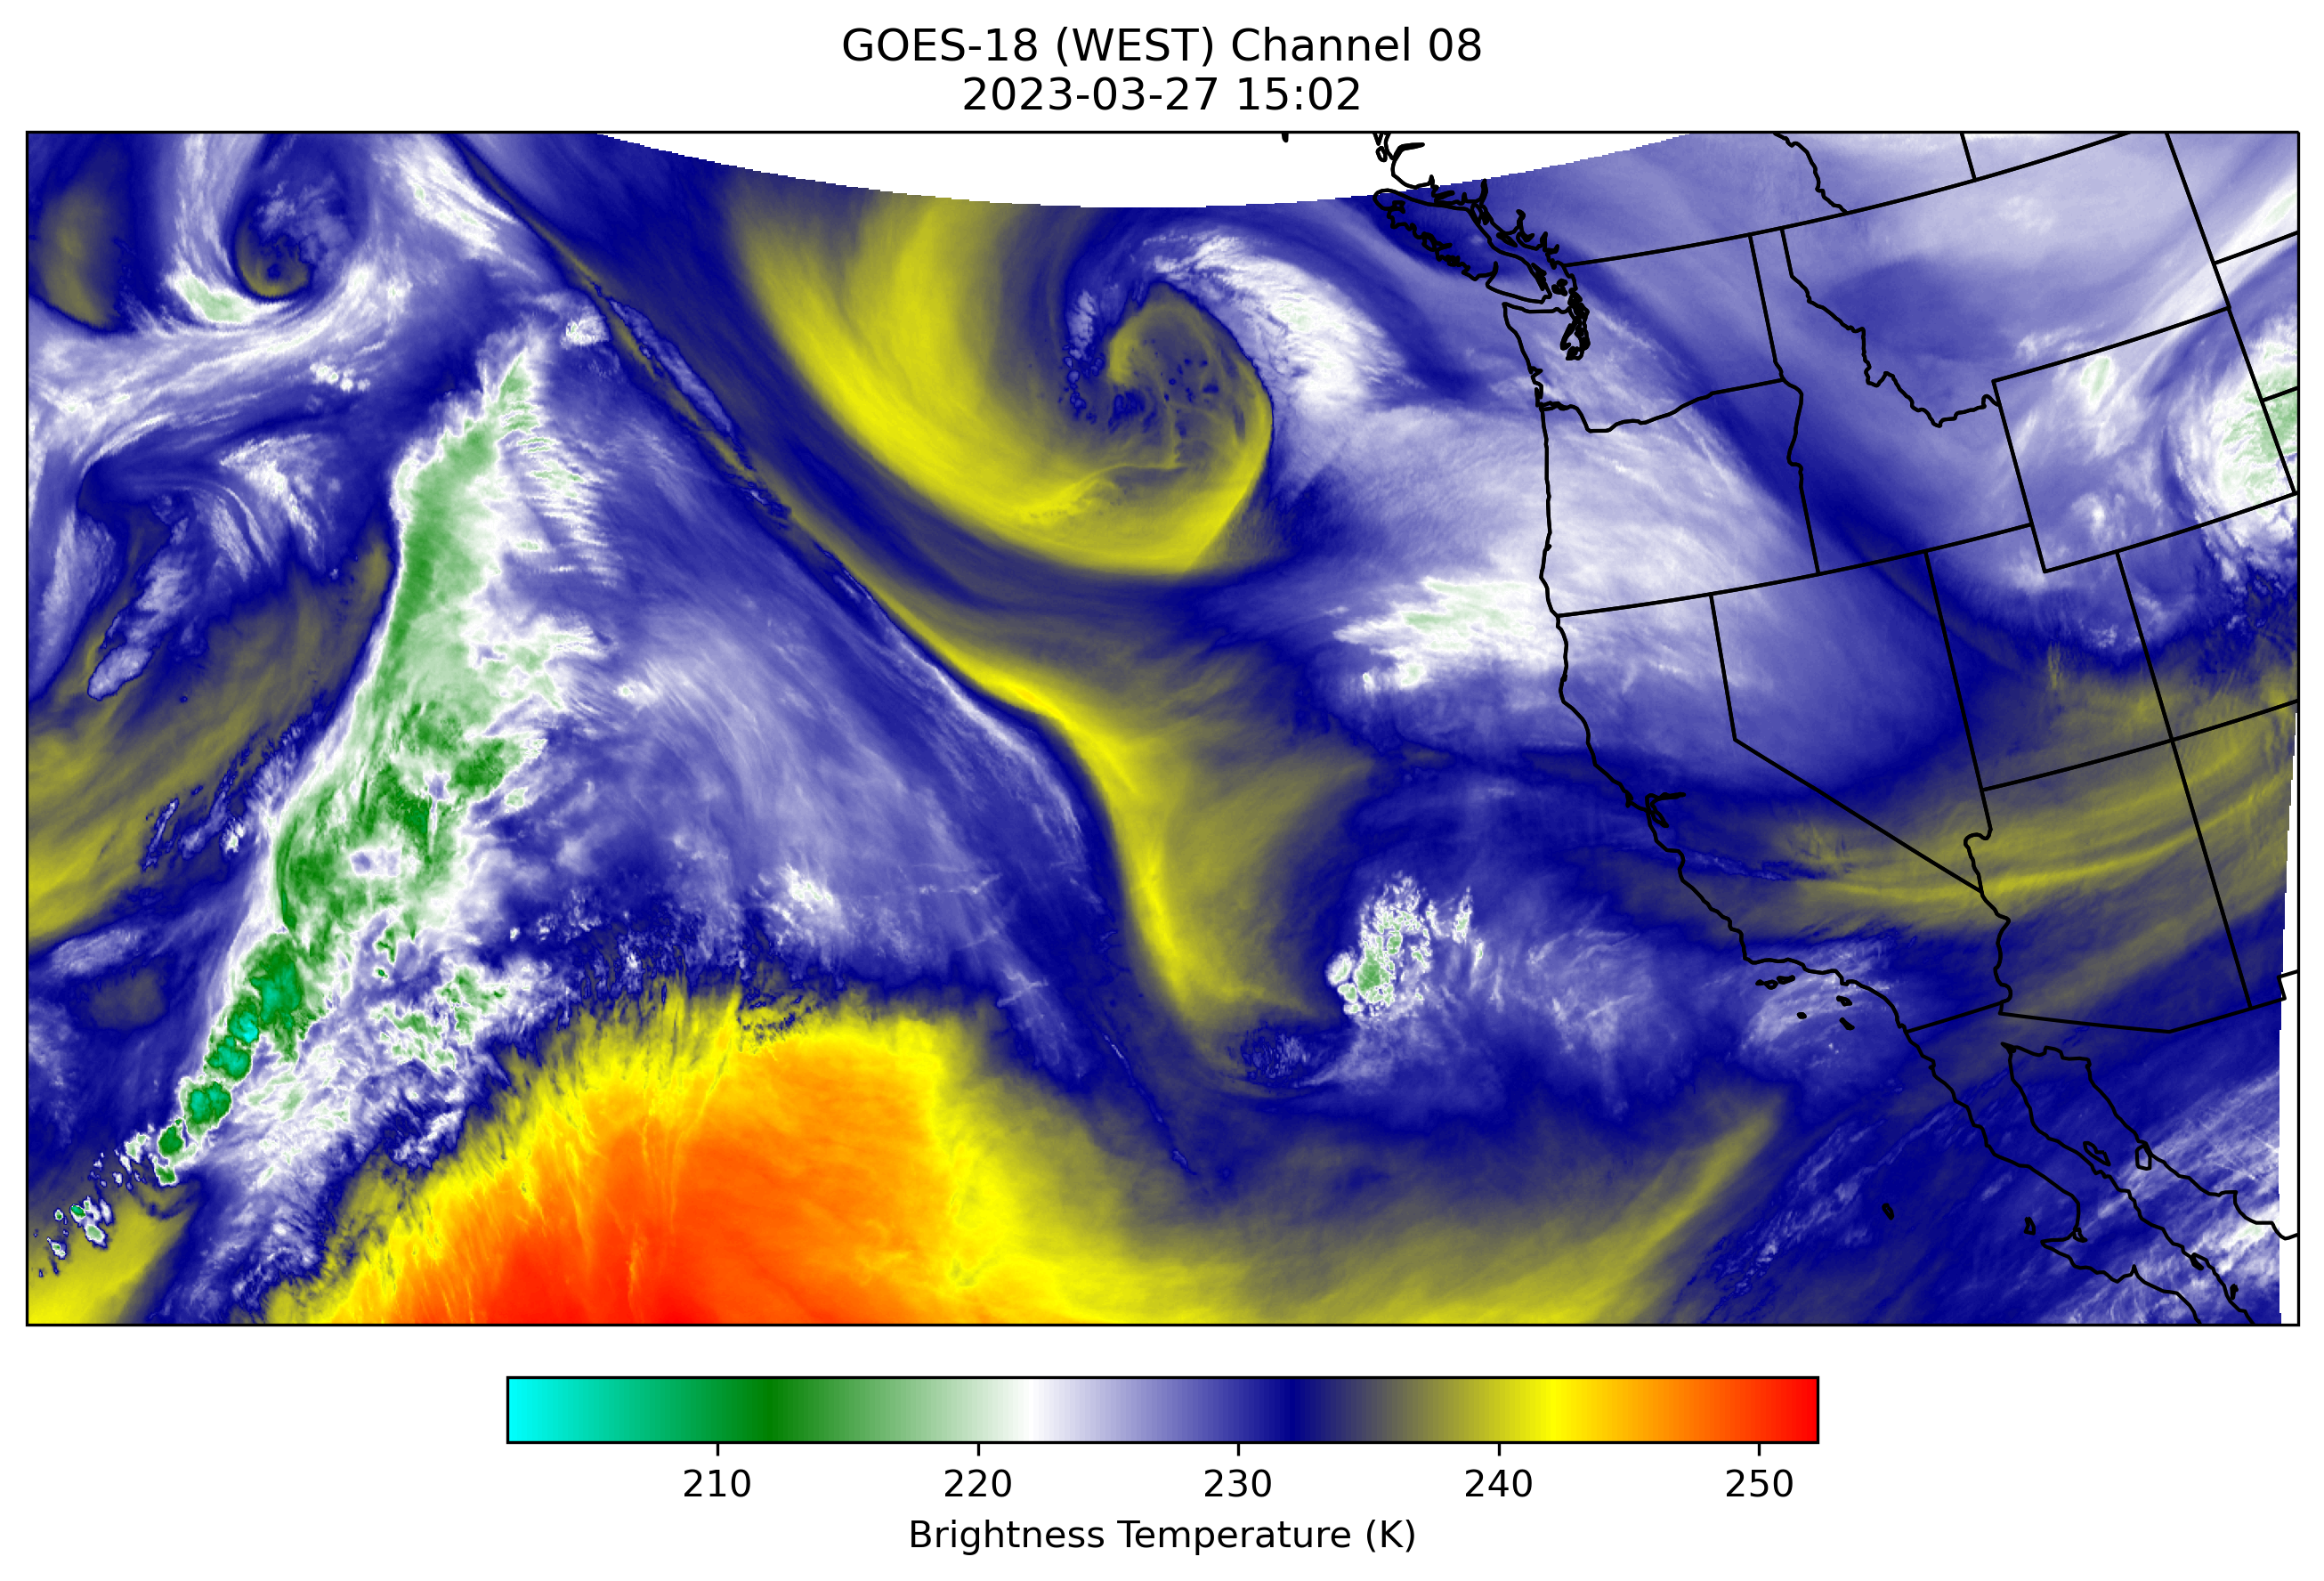

In [76]:
proj = ccrs.LambertConformal(central_latitude=(lat_min+lat_max) / 2,
                                     central_longitude=(lon_min+lon_max) / 2)

fig=plt.figure(figsize=(11,6.5),dpi=300)
ax = fig.add_subplot(1,1,1,projection=proj)
#img = plt.imread('../basemaps/natural_earth.tif')
#img_extent = (-180,180,-90,90)
#ax.imshow(img,origin='upper',extent=img_extent,transform=ccrs.PlateCarree())
#ax.add_feature(cfeature.NaturalEarthFeature('physical','land','50m',facecolor='oldlace'))
#ax.add_feature(cfeature.NaturalEarthFeature('physical','ocean','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

if int(channel) <= 6:
    img = ax.imshow(rad,vmin=(np.nanmin(rad)-0.1),vmax=np.nanmax(rad),origin='upper',extent=img_extent,cmap='Greys_r',transform=ccrs.Geostationary(lon,h))
    cb = plt.colorbar(img,orientation='horizontal',fraction=0.05,pad=0.04,label='Reflectivity')
elif int(channel) >= 8 and int(channel) <= 10:
    #create water vapor colormap
    norm = plt.Normalize(164,273)
    cmap = mcolors.LinearSegmentedColormap.from_list("",["cyan","green","white","darkblue","yellow","red"])
    #c1 = plt.cm.GnBu(np.arange(0,256,1))
    #c2 = plt.cm.RdYlBu_r(np.arange(0,128,1))
    #colors = np.vstack((c1, c2))
    #mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
    img = ax.imshow(rad,origin='upper',extent=img_extent,cmap=cmap,transform=ccrs.Geostationary(lon,h))
    cb = plt.colorbar(img,orientation='horizontal',fraction=0.05,pad=0.04,label='Brightness Temperature (K)')
else:
    c1 = plt.cm.gist_rainbow(np.arange(0,256,1))
    c2 = plt.cm.gist_gray_r(np.arange(0,256,1))
    colors = np.vstack((c1, c2))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
    img = ax.imshow(rad,vmin=160,vmax=300,origin='upper',extent=img_extent,cmap=mymap,transform=ccrs.Geostationary(lon,h))
    cb = plt.colorbar(img,orientation='horizontal',fraction=0.05,pad=0.04,label='Brightness Temperature')


plt.title('%s Channel %s\n'%(string,channel) + r'%s'%(img_time.strftime('%Y-%m-%d %H:%M')))
